# Семинар 2. Фильтрация траектории расширенным фильтром Калмана (EKF) и Ансцентным фильтром (UKF)

In [ ]:
#@title
#%matplotlib
import time                         # библиотека функций системного времени
import numpy as np                  # библиотека математических функций
import matplotlib.pyplot as plt     # библиотека построения графиков

T = 50                              # продолжительность траектории
dt = 1                              # шаг дискретизации траектории
time_series = np.arange(1,T,dt)     # отсчеты времени

F = np.array(   [[1.0,  dt],        # матрица перехода текущего состояния в будущее
                [0.0,  1.0]])

F1 = np.array(  [[1.0,  dt, 0.0, 0.0],
                 [0.0, 1.0, 0.0, 0.0],
                 [0.0, 0.0, 1.0,  dt],
                 [0.0, 0.0, 0.0, 1.0]])

G = np.array([dt**2/2, dt])         # матрица связи возмущающего воздействия с вектором состояния объекта

G1 = np.array(  [[dt**2/2,   0.0],
                 [dt,        0.0],
                 [0.0,   dt**2/2],
                 [0.0,   dt     ]])

X = np.array([0,10])                # начальное значение вектора состояния объекта

X1= np.array([[0.0],
              [10.0],
              [10.0],
              [0.0]])
process_noise = 1                   # СКО возмущающего воздействия
np.random.seed(0)                   # выбор случайной последовательности

X_log = {'time':[0], 'state':[X1]}   # сохранение данных для отображения
for t in time_series:
    ax = np.random.normal(0, process_noise)
    ax1 = np.random.normal(0, process_noise, (2, 1))
    X1 = F1@X1 + G1@ax1
    X = F@X + G*ax
    X_log['time'].append(t)
    X_log['state'].append(X1)

x = [X_log['state'][i][0] for i in range(len(X_log['state']))]  # выборка комопненты 'х' ~ [0] из вектора состояния

H = [1.0, 0.0, 1.0, 0.0]
sigma = 30
z_log = []
for i in range(len(X_log['state'])):
    e = np.random.normal(0, sigma, (2,1))
    z = H@X_log['state'][i] + e
    z_log.append(z)

## Линейная рекуррентная фильтрация (линейный фильтр Калмана)

* при рекуррентной оценке траекторных параметров требуется знание модели оцениваемого процесса и модели измерений
* уточнение вектора состояния оцениваемого процесса осуществляется после поступления каждого нового измерения $z_k$ и базируется лишь на данных о параметрах предыдущего шага $X_{k-1}$
* точность оценки не ограничивается фиксированным числом используемых данных
* не требуется повторения расчётов при использовании "старых" измерений
* организация рекуррентного вычислительного процесса наиболее удобна при наблюдении в течение неопределенного числа тактов

 Априорные сведения о модели модели движения цели и модели измерений предполагают следующие допущения, называемые **линейными гауссовскими допущениями** :
 * начальное состояние системы являются случайным вектором $X_0$ с определенным математическим ожиданием $M\lbrace X_0 \rbrace$ и ковариационной матрицей траекторных параметров $P_0$
 * детерминированное входное воздействие (управление) $u_k$ , если оно имеется, известно
 * случайное возмущение $w_k$ траекторных параметров имеет характер гауссовского шума с нулевым средним и **известной** ковариационной матрицей $Q_k$
 * ошибки измерений (шум наблюдений $e_k$) представляют собой процесс типа гауссовского шума с нулевым средним и **известной** ковариационной матрицей $R_k$
 * случайные процессы $w_k$ и $e_k$ взаимно не коррелированны
 * начальное состояние $X_0$ не коррелировано с возмущениями $w_k, e_k$

Пусть модель динамической системы (модель оцениваемого процесса) описывается векторным линейным разностым уравнением вида
$$ X_{k+1} = F_kX_k+B_k u_k + G_k w_k,$$
а модель наблюдений - линейным уравнением вида
$$ z_{k} = H_kX_{k}+e_k.$$
Пусть справедливо линейное гауссовское допущение для выбранных моделей, тогда рекуррентный фильтр будет представлять с собой два последовательно соединённых блока: 
1) **предсказателя**, вычисляющего состояние объекта на шаг вперед по уравнениям
$$X_{k|k-1} = F_k \hat{X}_{k-1}+B_k u_k$$
$$P_{k|k-1} = F_k \hat{P}_{k-1}F_k^T+G_k Q_k G_k^T$$
и формирующего ожидаемое измерение с ковариационной матрицей $S_k$
$$z_{k|k-1} = H_kX_{k|k-1}$$
$$S_k = H_k P_{k|k-1} H_k^T + R_k.$$

1) **корректора**, уточняющего предсказанное (экстраполированное) значение по результатам наблюдений по уравнениям
$$X_k = X_{k|k-1} + K_k(z_k-z_{k|k-1}),$$
$$P_k = P_{k|k-1}-K_kS_kK_k^T = [I-K_kH_k]P_{k|k-1},$$
при этом матричный коэффициент усиления фильтра Калмана находится из уравнения
$$K_k = P_{k|k-1}H_k^T S_k^{-1}.$$

* коэффициент усиления будет **большим**, если экстраполяция параметров траектории является **грубой**, а текущие измерения - **точными**
* коэффициент усиления будет **малым**, если прогноз параметров траектории является "точным", а текцщие измерения - **грубыми**.

На основе представленных выражений создадим класс, описывающий работу линейного Калмановского фильтра. Для этого выполните код ниже:

In [2]:
class KalmanFilter():
    """
    linear Kalman filter example
    """
    def __init__(self, process_noise_rms, measurement_noise_rms):
        # предсказанные значения вектора состояния
        self.predictedState = {'Xe':[], 'Pe':[], 'Se':[], 'K':[],'ze':[]}  
        # полученная оценка вектора состояния
        self.correctedState = {'X':[],'P':[]}
        self.settings = {'sigma_ax':process_noise_rms,'sigma_z':measurement_noise_rms}
        self.F = []
        self.K = []
        self.H = []
        
    def cv(self, X,P, dt):
        sa = self.settings['sigma_ax']
        F = np.array([[1, dt],[0,1]]).reshape(2,2)
        self.F = F
        G = np.array([dt**2/2, dt]).reshape(2,1)
        Q = np.array([sa**2]).reshape(1,1)
        Xe = F@X.reshape(2,1)
        Pe = (F@P)@np.transpose(F)+(G@Q)@np.transpose(G)
        return (Xe,Pe)
        
    def hcv(self,Xe,Pe):
        sz = self.settings['sigma_z']
        H = np.array([1, 0]).reshape(1,2)
        self.H = H
        R = np.array([sz**2]).reshape(1,1)
        ze = H@Xe
        Se = (H@Pe)@np.transpose(H)+R
        return (ze,Se,H)

    def predict(self, state_model, measurement_model, X, P, dt):
        (Xe,Pe) = state_model(X,P,dt)
        (ze,Se,H) = measurement_model(Xe,Pe)
        K = (Pe@np.transpose(H))@np.linalg.inv(Se)
        self.K = K
        self.predictedState['Xe'] = Xe
        self.predictedState['Pe'] = Pe
        self.predictedState['ze'] = ze
        self.predictedState['Se'] = Se
        self.predictedState['K'] = K
        
        return (Xe,Pe,ze,Se)
    
    def correct(self,z):
        Xe = self.predictedState['Xe']
        Pe = self.predictedState['Pe']
        ze = self.predictedState['ze']
        Se = self.predictedState['Se']        
        K = self.predictedState['K']
        X = Xe + K@(z-ze)
        P = Pe - (K@Se)@np.transpose(K)
        self.correctedState['X'] = X
        self.correctedState['P'] = P
        return (X,P)

Применим к измерениям, полученным на прошлом семинаре, Калмановскую фильтрацию и отобразим результат на графике

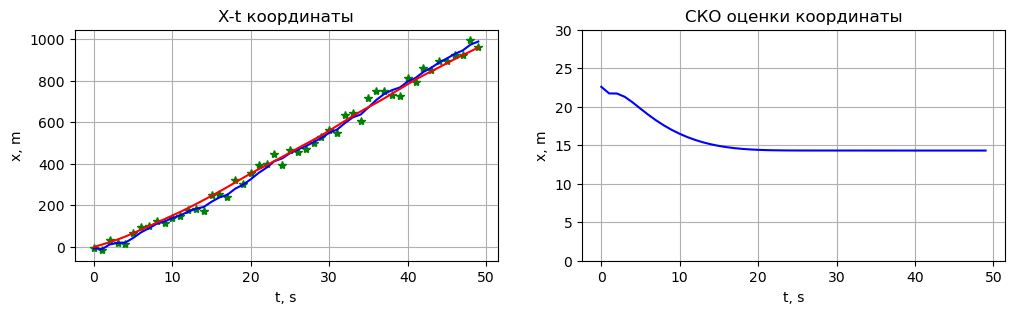

In [ ]:
vmax = 50                   # априорные сведения о максимальной скорости движения цели
kappa = 3                   # коэффициент расширения

measurement_noise_rms= 30  # СКО измерений
process_noise_rms = 1      # СКО модели оцениваемого процесса

kf = KalmanFilter(process_noise_rms,measurement_noise_rms)

xf = []  # массив отфильтрованных координат x
Pf = []  # массив ско координаты отфильтрованной координаты x

dt = 1   # темп получени измерений

# цикл по тактам траекторной обработки содержащим массивы измерений
for i in range(len(z_log)):
    z = z_log[i]    # считанное измерение за такт ТО
    if i == 0:
        # процедура инициализации вектора состояния
        X = np.array([z,0])  # (x,vx)^T
        P = np.array([[measurement_noise_rms**2,0],[0,(vmax/kappa)**2]])    
    
    # предсказываем положение цели на сопровождении за такт ТО
    (Xe,Pe,ze,Se) = kf.predict(kf.cv, kf.hcv, X,P, dt)
    
    # коррекция траекторий по результатам отождествления
    (X,P) = kf.correct(z)
    
    # сохранение данных для отображения
    xf.append(X[0])         
    Pf.append(np.sqrt(P[0][0]))
    
# рисуем оценку
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
# текущее измерение и отфильтрованная координата, исходные данные
ax1.plot(X_log['time'], z_log,'*g', # измеренные значения
         X_log['time'], xf, 'b', # корректированные значения
         X_log['time'], x, 'r') # реальные значения
ax1.grid(), ax1.set_title('X-t координаты'), ax1.set_xlabel('t, s'), ax1.set_ylabel('x, m')
ax2.plot(X_log['time'], Pf, 'b')
ax2.grid(), ax2.set_title('СКО оценки координаты'), ax2.set_xlabel('t, s'), ax2.set_ylabel('x, m')
ax2.set_ylim(0,30)
pass


*Из графиков видно, что СКО оценки ниже чем СКО измерений при выборе модели оцениваемого процесса с низким значением СКО возмущающего процесса. Что произойдет, если СКО возмущающего процесса увеличить? уменьшить?*

Рассмотрим работу фильтра Калмана с точки зрения его комплексно-частотной характеристики. Рекуррентное соотношение для оценки траекторных параметров соответствует подклассу [БИХ-фильтров](https://en.wikipedia.org/wiki/Infinite_impulse_response), откуда следует, что реакция фильтра $X$ на входное воздействие $z$ может быть найдена по следующему соотношению: 
$$X[n] =  \sum_{i=0}^P b_i z[n-i] + \sum_{i=1}^Q a_i X[n-i]$$

Передаточная характеристика фильтра будет иметь вид:
$$H(e^{-j\omega_k t}) = \frac{X(e^{-j\omega_k t})}{z(e^{-j\omega_k t})} = \frac{\sum_{i=0}^P b_i\cdot e^{-j\omega_k t}}{1-\sum_{i=1}^Q a_i\cdot e^{-j\omega_k t}}$$

Тогда, для линейного фильтра Калмана из уравнений предсказателя получаем следующие значения коэффициентов:
$$a_1 = F-KHF, b_0 = K$$

Из формул видно, что АЧХ фильтра будет изменяться, т.к. изменяется коэффициент усиления $K$. Построим комплексно-частотную характеристику фильтра, полученного ранее, в установившемся режиме, выполнив код ниже:

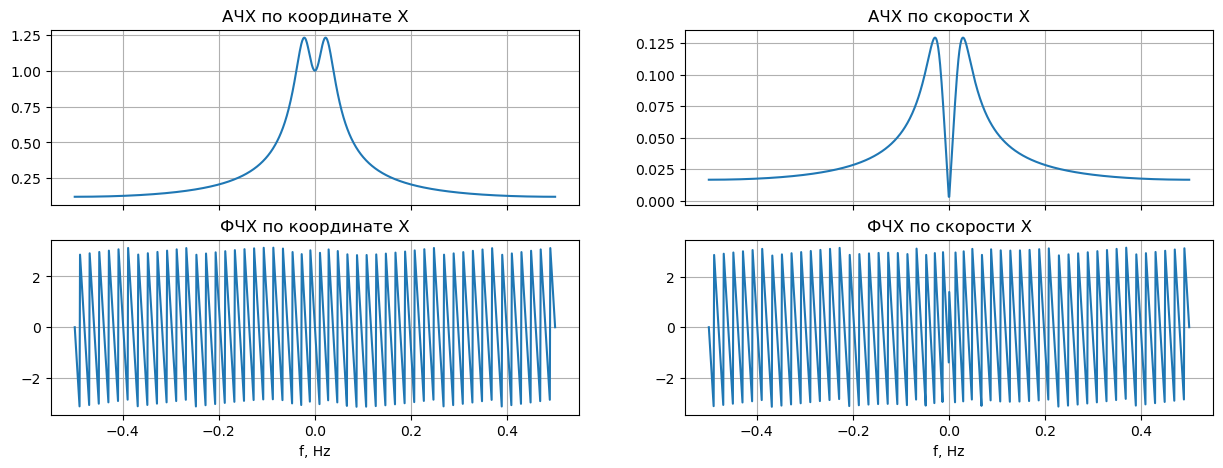

In [4]:
freqs = np.linspace(-1/2/dt,1/2/dt,1000)    # шкала частот для заданного шага прихода измерений

a1 = kf.F-kf.K@(kf.H@kf.F)                  # значения матриц были инициализированы ранее в процессе работы фильтра
b0 = kf.K

transfer_function = []
for f in freqs:
    nom = b0*np.exp(-1j*2*np.pi*f*T)
    den = np.linalg.inv(np.eye(2)-a1*np.exp(-1j*2*np.pi*f*dt))
    transfer_function.append(np.matmul(den,nom).squeeze())   # порядок перемножения имеет значение, домножение на обратную матрицу слева

# выделение компонент из комплексного вектора коэффициента передачи
Ajw_X = [np.abs(transfer_function[i][0]) for i in range(len(freqs))]
Pjw_X = [np.angle(transfer_function[i][0]) for i in range(len(freqs))]
Ajw_VX = [np.abs(transfer_function[i][1]) for i in range(len(freqs))]
Pjw_VX = [np.angle(transfer_function[i][1]) for i in range(len(freqs))]

fig, ((ax1,ax3),(ax2,ax4)) = plt.subplots(2,2, sharex=True, figsize=(15,5))
ax1.plot(freqs,Ajw_X), ax1.grid(), ax1.set_title('АЧХ по координате X')
ax2.plot(freqs,Pjw_X), ax2.grid(), ax2.set_title('ФЧХ по координате X'), ax2.set_xlabel('f, Hz')
ax3.plot(freqs,Ajw_VX), ax3.grid(), ax3.set_title('АЧХ по скорости X')
ax4.plot(freqs,Pjw_VX), ax4.grid(), ax4.set_title('ФЧХ по скорости X'), ax4.set_xlabel('f, Hz')
pass

*Как изменится АЧХ фильтра Калмана при увеличении СКО шумового воздействия в 10 раз? Объясните, почему АЧХ коэффициента передачи по скорости равна 0 на нулевой частоте?*

## Расширенный фильтр Калмана (Extended KF)

Общий вид нелинейной модели движения и нелинейной модели измерений 
$$ X_k = f_k(X_{k-1})+\gamma_k(X_{k-1})w_k,$$ 
$$ Z_k = h_k(X_k) + e_k, $$
где $f(\cdot), \gamma(\cdot), h(\cdot)$ - матричные нелинейные функции

Расширенный фильтр Калмана первого порядка основан на:
* линеаризации нелинейностей в уравнении модели движения целей и модели измерений
* оценивании траекторных параметров по формулам линейной калмановской фильтрации

Введем линеаризованные матрицы модели состояния и измерений
$$ F_k^T = \nabla_X \left[ f_k(X)^T\right]_{X = \hat{X}_{k-1}} \quad G_k = \left[ \gamma_k(X)^T\right]_{X = \hat{X}_{k-1}} \quad H_k^T = \nabla_X \left[ h_k(X)^T\right]_{X = X_{k|k-1}} $$
* уравнения экстраполяции калмановского фильтра примет вид:
$$ X_{k|k-1} = f_k(\hat{X}_{k-1}) $$
$$ P_{k|k-1} = F_k \hat{P} F_k^T + G_k Q_k G_k^T $$
$$ Z_{k|k-1} = h_k(X_{k|k-1}) $$
$$ S_{k|k-1} = H_k P_{k|k-1} H_k^T + R_k$$
$$ K_k = P_{k|k-1} H_k^T S_k^{-1} $$
* оценка траекторных параметров
$$\hat{X}_k = X_{k|k-1}+K_k(Z_k - Z_{k|k-1})$$
$$\hat{P}_k = [I-K_k H_k] P_{k|k-1} $$

Пусть модель движения описывается полиномом 1 степени на плоскости ($X=[x, v_x, y, v_y]^T$), а измерения приходят в полярной системе координат и имеют вид $z = [\rho, \phi]^T$, тогда, составляющие уравнений Калмановской фильтраци будут иметь вид:
$$F_k^T = \nabla_X \left[ f_k(X)^T\right]_{X = \hat{X}_{k-1}} = 
\begin{bmatrix} 
1 & dt & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & dt \\
0 & 0 & 0 & 1 \\
\end{bmatrix}^T \quad
G_k = \left[ \gamma_k(X)^T\right]_{X = \hat{X}_{k-1}} = \begin{bmatrix} 
dt^2/2 & 0 \\
dt & 0 \\
0 & dt^2/2 \\
0 & dt \\
\end{bmatrix}
$$

$$
h(X_k) = \begin{bmatrix} \sqrt{x^2+y^2} \\ \arctan \left( \frac{y}{x} \right)\end{bmatrix} \quad
H_k^T = \nabla_X \left[ h_k(X)^T\right]_{X = X_{k|k-1}} = \begin{bmatrix} 
\frac{x}{\sqrt{x^2+y^2}} & 0 & \frac{y}{\sqrt{x^2+y^2}} & 0 \\
\frac{-y}{x^2+y^2} & 0 & \frac{x}{x^2+y^2} & 0 \\
\end{bmatrix}^T
$$

## Задание №1

Скопируйте класс линейного фильтр Калмана и модифицируйте его таким образом, чтобы фильтровать измерения в полярной системе координат, полученные в прошлом семинаре. Модель оцениваемого процесса должна быть двумерной CV по координатам (x,y). Погрешность измерений должна быть взята из прошлого семинара, а СКО случайного возмущения по каждой кординате примите равной $\sigma_{ax} = \sigma_{ay} = 1 м/с/с$.

In [5]:
# напишите свой код в этом блоке

## Ансцентный фильтра Калмана (Uncented KF)

Ансцентное преобразование это -
* вариант аппроксимации симметричной полтности вероятности оцениваемого процесса
* способ вычисления статистик подвергнутых нелинейному преобразованию
* принцип, что легче применить нелинейное преобразование к одиночной или группе точек, чем к плотности вероятности в целом
* принцип того, что найти группу точек, максимально аппроксимирующих истинную плотность вероятности, достаточно просто

Пусть модели оцениваемого процесса и измерений описывается следующими нелинейными соотношениями:
$$ X_k = f(X_{k-1}) + w_k $$
$$ z_k = h(X_k)+e_k$$

Тогда, после получения измерения на $k$-м шаге для заранее найденных весов $w_i$, например для обобщенного ансцентного преобразования:
$$ \quad w_0 = \kappa/(n+\kappa), w_i = 1/2(n+\kappa) $$
* $\kappa$ - масштабный коэффициент настройки

1. вычислить сигма-точки и их весовые коэффициенты
$$ \chi_{i,k-1} = \left\{ \hat{x}_{k-1}, \hat{x}_{k-1} + \sqrt{(n+\kappa)\hat{P}_{i,k-1}}, \hat{x}_{k-1} - \sqrt{(n+\kappa)\hat{P}_{i,k-1}}\right\} $$

2. вычисление экстраполированных сигма-векторов и экстраполированных оценок
$$\chi_{i,k|k-1} = f(\chi_{i,k-1})$$
$$ \hat{X}_{k|k-1} = \sum_{i=0}^{2n} w_i \chi_{i,k|k-1}; \quad \hat{P}_{k|k-1} = \sum_{i=0}^{2n} w_i (\chi_{i,k|k-1}-\hat{X}_{k|k-1})(\chi_{i,k|k-1}-\hat{X}_{k|k-1})^T+Q_k$$

3. вычисление экстраполированного измерения
$$\mathcal{Z}_{i,k|k-1} = h(\chi_{i,k|k-1})$$
$$ \hat{z}_{k|k-1} = \sum_{i=0}^{2n} w_i \mathcal{Z}_{i,k|k-1}; \quad P_{zz} = \sum_{i=0}^{2n} w_i (\mathcal{Z}_{i,k|k-1}-\hat{z}_{k|k-1})(\mathcal{Z}_{i,k|k-1}-\hat{z}_{k|k-1})^T+R_k$$
4. вычисление коэффициента усиления фильтра
$$P_{xz} = \sum_{i=0}^{2n} w_i (\chi_{i,k|k-1}-\hat{X}_{k|k-1})(\mathcal{Z}_{i,k|k-1}-\hat{z}_{k|k-1})^T$$
$$K_k = P_{xz}P_{zz}^{-1}$$
5. вычисление выходной оценки фильтра
$$\hat{X}_k = \hat{X}_{k|k-1}+K_k(z_k-\hat{z}_{k|k-1}), \quad \hat{P}_k = \hat{P}_{k|k-1}-K_k P_{zz} K_k^T$$

Рассчитаем сигма-точки для вектора состояния, полученного ранее. Для этого выполним следующий код:

весовые коэффициенты сигма-векторов w = 0.33, 0.17, 0.17, 0.17, 0.17, 


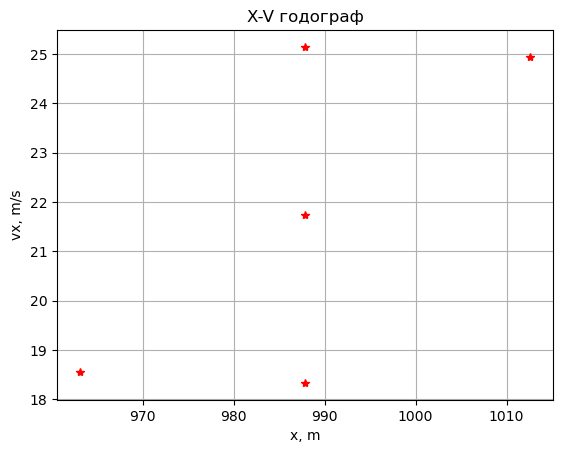

In [6]:
n = 2       # используется 1 мерная модель CV для координаты X
kappa = 1   # масштабный коэффициент, отвечает за разброс сигма-векторов

w0 = [kappa/(n+kappa)]
wi = [1/2/(n+kappa)]*(2*n)  # коэффициенты для всех смещенных сигма-векторов
w = w0 + wi
print('весовые коэффициенты сигма-векторов w =',''.join(f"{s:.2f}, " for s in w))

Xu = kf.correctedState['X'].squeeze()
D = np.linalg.cholesky((n+kappa)*kf.correctedState['P'])   # операция эквивалентная взятию корня из матрицы
u = np.array([Xu, Xu+D[:,0], Xu+D[:,1], Xu-D[:,0], Xu-D[:,1]])

plt.grid(), plt.plot(u[:,0],u[:,1], '*r'), plt.title('X-V годограф'), plt.xlabel('x, m'), plt.ylabel('vx, m/s')
pass

Сравним предсказания линейной модели и ансцентного преобразования

In [7]:
Xp = kf.correctedState['X'].reshape(2,1)
Pp = kf.correctedState['P'].reshape(2,2)
(Xe,Pe,ze,Se) = kf.predict(kf.cv, kf.hcv, Xp,Pp, dt)
print('KF prediction: \nXe = ',Xe.squeeze(), '\nPe = ', Pe.squeeze())

Ue = []
for i in range(len(u)):
    (ue,pe,ze,se) = kf.predict(kf.cv, kf.hcv, u[i],Pp, dt)
    Ue.append(ue) # сохранение предсказаний для сигма-векторов

# вычисление среднего взвешенного предсказания вектора состояния
Xu = np.zeros((2,1))
for i in range(len(u)):
    Xu = Xu + w[i]*Ue[i]
# вычисление среднего взвешенного предсказания матрицы ковариации вектора состояния
Pu = np.zeros((2,2))
for i in range(len(u)):
    dU = Ue[i]-Xu
    Pu = Pu + w[i]*(dU.reshape(2,1)@dU.reshape(1,2))
    
print('UKF prediction: \nXu = ',Xu.squeeze(), '\nPu = ', Pu.squeeze())

KF prediction: 
Xe =  [1009.57822969   21.7365515 ] 
Pe =  [[264.92872782  34.13110613]
 [ 34.13110613   8.26213741]]
UKF prediction: 
Xu =  [1009.57822969   21.7365515 ] 
Pu =  [[264.67872782  33.63110613]
 [ 33.63110613   7.26213741]]


## Задание №2

Скопируйте класс расширенного фильтра Калмана и модифицируйте его таким образом, чтобы превратить его в ансцентный фильтр Калмана (пусть масштабный коэффициент настройки $\kappa = 1$). Для данных полученных на прошлом семинаре сравните результаты фильтрации фильтров ЛФК, РФК и АФК, представив на одном графике полученные траектории, а на другом - оценку СКО координаты вектора состояния.

In [ ]:
# напишите свой код здесь
